#### **Gaussian Processes**

In [ ]:
'''
Gaussian Processes are everywhere so how we look into them and know how to use them
is very important for reasoning about model construction and generalization, for
achieving the state-of-the-art.

1. Gaussian process priors over functions
2. Use these priors to do posterior inference and serve predictions
'''

In [ ]:
from scipy.spatial import distance_matrix
from scipy import optimize

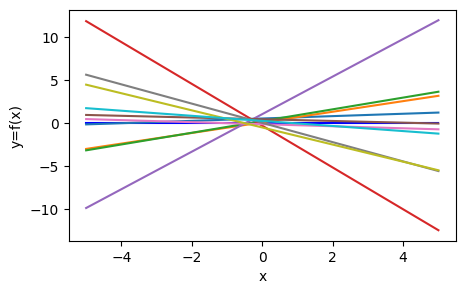

In [ ]:
''' A simple Gaussian Process '''
def line_fn(x, sample):
  predictions = np.zeros((sample, x.shape[0]))
  for i in range(sample):
    w = np.random.normal(0, 1, 2)
    y = w[0] + x * w[1]
    predictions[i, :] = y
  return predictions

x_points = np.linspace(-5, 5, 50)
y_points = line_fn(x_points, 10)
lower_bound = -2*np.sqrt((1 + x_points**2))
upper_bound = -2*np.sqrt((1 + x_points**2))

plt.figure(figsize=(5, 3))
plt.fill_between(x_points, lower_bound, upper_bound, alpha=0.25)
plt.plot(x_points, np.zeros(len(x_points)), color='blue')
plt.plot(x_points, y_points.T)
plt.xlabel('x') ; plt.ylabel('y=f(x)')
plt.show()

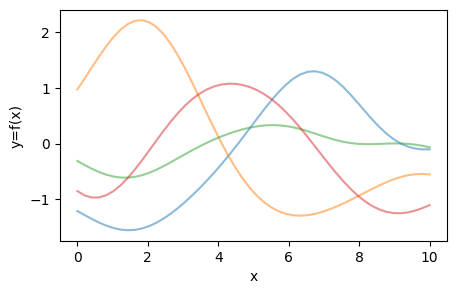

In [ ]:
''' from weight space to function space, RBF kernel '''
def  rbfkernel(x1, x2, ls=4.):
  dist = distance_matrix(np.expand_dims(x1, 1), np.expand_dims(x2, 1))
  #return np.exp(-dist**2 / ls**2)
  return np.exp(-(1./ls /2) * (dist**2))

x_points = np.linspace(0, 10, 50)
meanvec = np.zeros(len(x_points))
covmat = rbfkernel(x_points, x_points, ls=4.)
prior_samples = np.random.multivariate_normal(meanvec, covmat, size=4)
plt.figure(figsize=(5, 3))
plt.plot(x_points, prior_samples.T, alpha=.5)
plt.xlabel('x') ; plt.ylabel('y=f(x)')
plt.show()

Making Predictions and Learning Kernel Hyperparameters in Gaussian Process

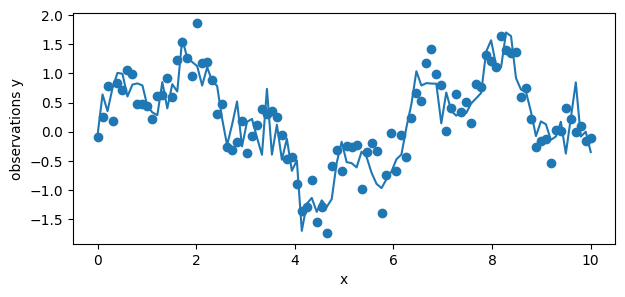

In [ ]:
'''
Create some regression data, fit them into a Gaussian Process each step.
The noise free function and use a noise standard deviation sigma = .25
'''
def data_make(x, sig):
  y = np.sin(x) + .5 * np.sin(4*x) + np.random.randn(x.shape[0])* sig
  return y

sig = .25
train_x, test_x = np.linspace(0, 10, 100), np.linspace(0, 10, 100)
train_y, test_y = data_make(train_x, sig), data_make(test_x, sig)
plt.figure(figsize=(7, 3))
plt.scatter(train_x, train_y, label='train')
plt.plot(test_x, test_y, label='test')
plt.xlabel('x', fontsize=10)
plt.ylabel('observations y', fontsize=10)
plt.show()

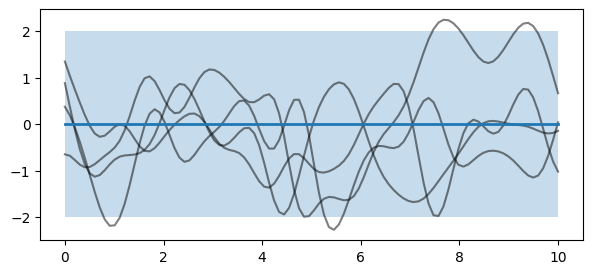

In [ ]:
''' noisy observations as circles, noise free line

specify GP over the latent noise-free function
use a mean function and an RBF covariance function kernel
'''
mean = np.zeros(test_x.shape[0])
cov = rbfkernel(test_x, test_x, ls=.2)
''' we started with a length-scale of .2, before we fit the data, consider if
we have specified reasonable priors -- visualize sample functions and a
95% credible set '''
prior_samples = np.random.multivariate_normal(mean, cov, size=4)
plt.figure(figsize=(7, 3))
plt.plot(test_x, prior_samples.T, alpha=.5, color='black')
plt.plot(test_x, mean, linewidth=2.)
#plt.fill_between(test_x, prior_samples.min(axis=0), prior_samples.max(axis=0), alpha=.25)
plt.fill_between(test_x, mean -2*np.diag(cov), mean +2*np.diag(cov), alpha=.25)
plt.show()

In [ ]:
''' Let's form the mean and variance of the posterior predictive distribution
at an arbitrary test point. Let's learn our kernel hyper-parameters and noise
variance. Let's initialize length-scale of .75, and guess a noise std sigma 0.75
Maximize the marginal likelihood with respect to these parameters.
For our prior functions, let's guess a lengthy-scale of 0.4, and std of 0.75.
These are the hyperparameter initializations learn these from marginal likelihood
'''
el_est = .4 ; post_sig_est = .5

def negMLL(pars):
  K = rbfkernel(train_x, train_x, ls=pars[0])
  kernel_term = -.5 * train_y @ \
              np.linalg.inv(K +pars[1]**2 * np.eye(train_x.shape[0])) @ train_y
  lodget = -.5 * np.log(np.linalg.det(K + pars[1]**2 * np.eye(train_x.shape[0])))
  const = -train_x.shape[0]/2.  * np.log(2 * np.pi)
  return -(kernel_term + lodget + const)

learned_pars = optimize.minimize(negMLL, x0=np.array([el_est, post_sig_est]),
                                 bounds=((0.01, 10.), (0.01, 10.)))
ell = learned_pars.x[0]
post_sig = learned_pars.x[1]
print(learned_pars)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 48.32505689549152
        x: [ 3.005e-01  2.829e-01]
      nit: 7
      jac: [-4.519e-04 -2.281e-04]
     nfev: 27
     njev: 9
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


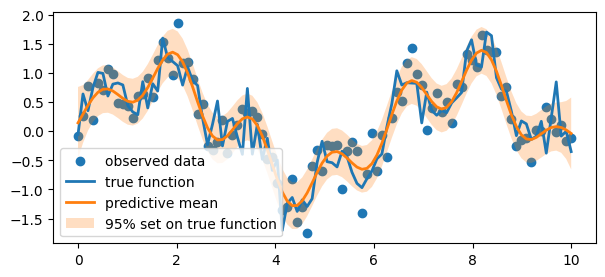

In [ ]:
''' make predictions with learned hyperparameters '''
K_x_xstar = rbfkernel(train_x, test_x, ls=ell)
K_x_x = rbfkernel(train_x, train_x, ls=ell)
K_xstar_xstar = rbfkernel(test_x, test_x, ls=ell)
post_mean = K_x_xstar.T @ \
    np.linalg.inv(K_x_x + post_sig_est**2 * np.eye(train_x.shape[0])) @ train_y
post_cov = K_xstar_xstar - K_x_xstar.T @ \
    np.linalg.inv(K_x_x + post_sig_est**2 * np.eye(train_x.shape[0])) @ K_x_xstar

lower_bound = post_mean - 2*np.sqrt(np.diag(post_cov))
upper_bound = post_mean + 2*np.sqrt(np.diag(post_cov))

plt.figure(figsize=(7, 3))
plt.scatter(train_x, train_y, label='train')
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.fill_between(test_x, lower_bound, upper_bound, alpha=.25)
plt.legend(['observed data', 'true function', 'predictive mean', '95% set on true function'])

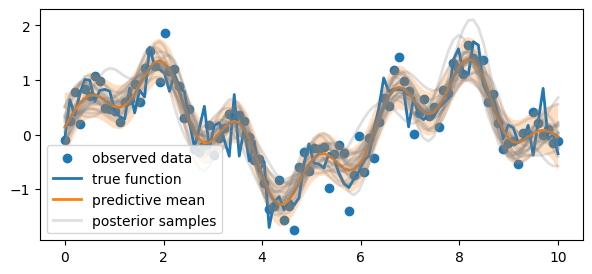

In [ ]:
lower_bound_observed = post_mean - 2*np.sqrt(np.diag(post_cov) + post_sig_est**2)
upper_bound_observed = post_mean + 2*np.sqrt(np.diag(post_cov) + post_sig_est**2)

post_samples = np.random.multivariate_normal(post_mean, post_cov, size=20)

plt.figure(figsize=(7, 3))
plt.scatter(train_x, train_y, label='train')
plt.plot(test_x, test_y, linewidth=2.)
plt.plot(test_x, post_mean, linewidth=2.)
plt.plot(test_x, post_samples.T, linewidth=2., alpha=.25, color='gray')
plt.fill_between(test_x, lower_bound, upper_bound, alpha=.25)
plt.legend(['observed data', 'true function', 'predictive mean', 'posterior samples'])

In [ ]:
''' Make use of GPyTorch library '''
import gpytorch
train_x, train_y, test_y = torch.tensor(train_x), torch.tensor(train_y), torch.tensor(test_y)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
''' Initialize Gaussian likelihood '''
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
training_iter = 50
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad() # zero gradients from previous iterations
    output = model(train_x) # model output
    loss = -mll(output, train_y) # loss function and backprop gradients
    loss.backward()
    if i % 10 == 0:
        print(f'Iter {i+1:d}/{training_iter}, loss: {loss.item():.2f}'
      f'\t - squared lengthscale: {model.covar_module.base_kernel.lengthscale.item():.2f}',
      f'\t - noise variance: {model.likelihood.noise.item():.3f}'  )
    optimizer.step()

Iter 1/50, loss: 1.00	 - squared lengthscale: 0.69 	 - noise variance: 0.693
Iter 11/50, loss: 0.72	 - squared lengthscale: 0.45 	 - noise variance: 0.313
Iter 21/50, loss: 0.51	 - squared lengthscale: 0.46 	 - noise variance: 0.130
Iter 31/50, loss: 0.48	 - squared lengthscale: 0.49 	 - noise variance: 0.067
Iter 41/50, loss: 0.48	 - squared lengthscale: 0.48 	 - noise variance: 0.065


In [ ]:
''' Get into evaluation (predictive posterior) mode '''
model.eval()
likelihood.eval()
test_x = torch.tensor(test_x)
observer_pred = likelihood(model(test_x))

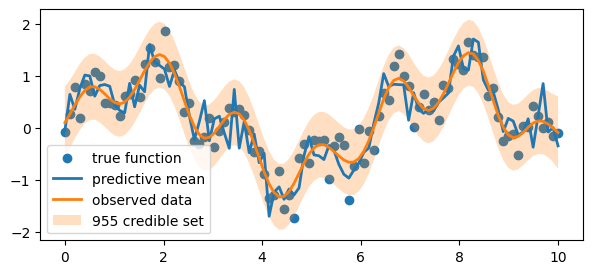

In [ ]:
''' finally, we are here! make predictions on test inputs '''
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    lower, upper = observer_pred.confidence_region()
    plt.figure(figsize=(7, 3))
    plt.scatter(train_x, train_y, label='train')
    plt.plot(test_x, test_y, linewidth=2.)
    plt.plot(test_x, observer_pred.mean, linewidth=2.)
    plt.fill_between(test_x, lower, upper, alpha=.25)
    plt.legend(['true function', 'predictive mean',
                'observed data', '955 credible set', ])